<a> </a>
# Translater - Build a model and train 
## Encoder - Decoder Model 

<a> </a>
## 1) Imports

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.preprocessing.text import Tokenizer
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding, LSTM, TimeDistributed,RepeatVector


<a> </a>
## 2) Load dataset - validation and training set

In [2]:
def loadDataSet(filename):
    return pd.read_csv(filename)
    
 
#load datasets
train = loadDataSet('portugueseEnglishTrain.csv')
valid = loadDataSet('portugueseEnglishValid.csv')

In [3]:
#limitation to be solved - memory
train = train[:12000]
train

,portuguese,english
0,this is where my dad works,meu pai trabalha aqui
1,tom and mary both failed the exam,tom e mary ambos falharam no exame
2,tom knew what had to be done,tom sabia o que tinha que ser feito
3,these are real,estas sao verdadeiras
4,tom thought i knew mary,tom pensou que eu conhecia mary
...,...,...
11995,tom is very dangerous,tom e muito perigoso
11996,would you mind if we talked about this later,voce se importaria se falassemos disso depois
11997,i wasnt the one who helped tom,nao fui eu quem ajudou tom
11998,everything stopped,todos pararam


In [4]:
#limitation to be solved
valid = valid[:3000]
valid


,portuguese,english
0,were going to make it,nos vamos fazer
1,tom tried the door,tom tentou abrir a porta
2,tom says a lot of things he doesnt mean,o tom diz muitas coisas que ele nao quer dizer
3,tom divorced mary,o tom se divorciou da mary
4,i have a lot of things to do,estou com um bocado de coisas a serem feitas
...,...,...
2995,you know that i cant do that dont you,voces sabem que nao posso fazer isso nao e
2996,scientists havent found a cure for cancer yet,os cientistas ainda nao descobriram uma cura p...
2997,tom and mary played together a lot when they w...,tom e mary sempre brincavam juntos quando eram...
2998,can i come in,posso entrar


<a></a>
## 3) Transform words in integers and prepare the data 

In [5]:
# use the Keras Tokenize class to map words to integers, as needed for modeling.

# fit a tokenizer
def create_tokenizer(sentence):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentence)
    return tokenizer

#find the size longest sentence
def max_length(lines):
    return max(len(line.split()) for line in lines)

#all dataset
dataset = pd.concat([train, valid])
valid = np.asarray(valid)
train = np.asarray(train)
dataset = np.asarray(dataset)


# prepare portuguese tokenizer
port_tokenizer = create_tokenizer(dataset[:, 0])
port_vocab_size = len(port_tokenizer.word_index) + 1
port_length = max_length(dataset[:, 0])
print('Portuguese Vocabulary Size: %d' % port_vocab_size)
print('Portuguese Max Length: %d' % (port_length))


# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 1])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 1])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length of one Sentence: %d' % (eng_length))



Portuguese Vocabulary Size: 5134
Portuguese Max Length: 25
English Vocabulary Size: 7579
English Max Length of one Sentence: 27


In [6]:
# encode and pad sequences

#input will be word embedding vector -The benefit of this approach is that different words with similar meaning will have a similar representation.
#output will be one-hot encoding!

#Each input and output sequence must be encoded to integers and padded to the maximum phrase length. 
#This is because we will use a word embedding for the input sequences and one hot encode the output sequences 
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    X = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    X = pad_sequences(X, maxlen=length, padding='post')
    return X



# one hot encode target sequence
#The output sequence is in one-hot encoded format
#This is because the model will predict the probability of each word in the vocabulary as output.
def oneHotEncoding_output(sequences, vocab_size):
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = np.asarray(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y

trainPort = encode_sequences(port_tokenizer, port_length, train[:, 0])
trainEnglish = encode_sequences(eng_tokenizer, eng_length, train[:, 1])
trainEnglishD = oneHotEncoding_output(trainEnglish, eng_vocab_size)
# prepare validation data
validPort = encode_sequences(port_tokenizer, port_length, valid[:, 0])
validEnglish = encode_sequences(eng_tokenizer, eng_length, valid[:, 1])
validEnglishD = oneHotEncoding_output(validEnglish, eng_vocab_size)



In [7]:
trainPort

array([[ 16,   7,  71, ...,   0,   0,   0],
       [  2,  36,  24, ...,   0,   0,   0],
       [  2, 188,  25, ...,   0,   0,   0],
       ...,
       [  1, 166,   5, ...,   0,   0,   0],
       [172, 623,   0, ...,   0,   0,   0],
       [ 54,   6,  91, ...,   0,   0,   0]])

In [ ]:
#Isto é o que entra no embedding layer ou seja é a frase de tamanho = 27 pois é o tamanho maximo
trainEnglish.shape

In [ ]:
#isto é as labels. tem de estar em one-hot-encoding para dizer qual é a palavra esperada,
#pois a saida é uma softmax (distribuição de tamanho = tamanho dicionario, que neste caso é 7579)
trainEnglishD.shape

<a> </a>
# 4) Build the model

In LSTM case, besides h_t (hidden state), there is also $c_t$.
We can just think of $c_t$ as another type of hidden state. Similar to $h_0^l$, $c_0^l$ will be initialized to a tensor of all zeros. Also, our context vector will now be both the final hidden state and the final cell state, i.e. $z^l = (h_T^l, c_T^l)$.
$c_t$ is the cell state that exists in LSTM
Let’s go back to our example of a language model trying to predict the next word based on all the previous ones. In such a problem, the cell state might include the gender of the present subject, so that the correct pronouns can be used. When we see a new subject, we want to forget the gender of the old subject, and update the cell state with the new subject. Basically, is to preserve information/context. 


Regular RNNs do have just the hidden state and no cell state. It turns out that RNNs have difficulty of accessing information from a long time ago.

For instance, check these two long sentences:

Cows, that eat green green ... green grass are OK.

Cow, that eat green green ... green grass is OK.

It would be very hard for RNN to learn the singular/plural dependency, but LSTM are capable of doing that.


In this case we are going to use 1 RNN Layer, but we could use 2 RNN layer in the encoder. And this way it would be like in the next figure:

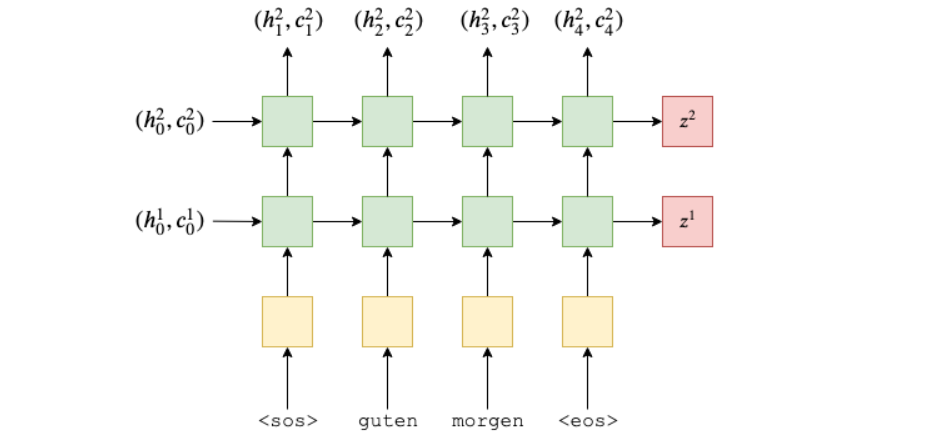

input_dim - is the size/dimensionality of the one-hot vectors that will be input to the encoder. This is equal to the input (source) vocabulary size.

emb_dim - is the dimensionality of the embedding layer. This layer converts the one-hot vectors into dense vectors with emb_dim dimensions.



In [8]:
def seq2seq_model_builder(src_vocab_size, target_vocab_size, src_max_length, target_max_length, embedding_dim):
    
    encoder_inputs = Input(shape=(src_max_length,))
    # a camada embedding basicamente cria uma matriz de tamanho igual ao tamanho do vocabulario
    # assim a posição 0 corresponde à palavra 0 do vocabulario, a palavra 100 corresponde a palavra 100 do vocabulario.
    #nao esquecer que cada frase ta codificada de acordo com o tokenId.. fica tipo [100, 150, 500]. depois quando esta frase entra
    #no embedding, vai, para a primeira palavra, à posição 100 da matriz que há no embedding, e nessa posição haverá um vetor
    # de tamanho 256 neste caso (que foi o que definimos como tamanho do embedding vector). O numero máximo que se pode encontrar numa frase
    # é igual ao tamanho do vocabulario, que por sua vez é o tamanho da matriz de embedding 
    #O Embedding guarda uma matriz de tamanho src_vocab_size * embedding_dim
    x = Embedding(src_vocab_size, embedding_dim, input_length= src_max_length)(encoder_inputs)
    x, state_h, state_c = LSTM(embedding_dim,
                           return_state=True)(x)
    encoder_states = [state_h, state_c]
    
    decoder_inputs = Input(shape=(target_max_length,))
    x = Embedding(target_vocab_size, embedding_dim,input_length= target_max_length)(decoder_inputs)
    x = LSTM(embedding_dim, return_sequences=True)(x, initial_state=encoder_states)
    decoder_outputs = TimeDistributed(Dense(target_vocab_size, activation='softmax'))(x)
    
    return Model([encoder_inputs, decoder_inputs], decoder_outputs)


model = seq2seq_model_builder(port_vocab_size, eng_vocab_size, port_length, eng_length, 256)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy')
# Note that `trainEnglishD` needs to be one-hot encoded,
model.fit([trainPort, trainEnglish],trainEnglishD, epochs=30, batch_size=64, validation_data=[(validPort, validEnglish),validEnglishD],  verbose=1)